In [1]:
# Cell 1: Installation and Improved Imports
!pip install librosa

import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# We switch to ResNet50V2 which is excellent for Transfer Learning on Spectrograms
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Audio playback
from IPython.display import Audio

# Plotting style
sns.set_style('darkgrid')

print("Libraries imported. Ready for the next step.")

Libraries imported. Ready for the next step.


In [2]:
# Cell 2: Data Loading & Label Encoding

from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Path (Update if your folder name is different)
AUDIO_DIR = '/content/drive/MyDrive/BabyCryProject/donateacry_corpus/'

if not os.path.exists(AUDIO_DIR):
    print(f"ERROR: Audio directory not found at {AUDIO_DIR}")
    # Fallback for testing if drive isn't populated
    os.makedirs('dummy_data/hungry', exist_ok=True)
    AUDIO_DIR = 'dummy_data/'
else:
    print("Audio directory found.")

# 3. Load File Paths and Labels
filepaths = []
labels = []

# Iterate through each folder (class)
for folder_name in os.listdir(AUDIO_DIR):
    folder_path = os.path.join(AUDIO_DIR, folder_name)

    # Check if it's a folder and not a hidden file
    if os.path.isdir(folder_path):
        # Find all .wav files
        wav_files = glob.glob(os.path.join(folder_path, '*.wav'))

        for wav in wav_files:
            filepaths.append(wav)
            labels.append(folder_name)

# 4. Create DataFrame
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# 5. Encode Labels (Text -> Numbers)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create a mapping dictionary (e.g., {0: 'belly_pain', 1: 'burping'...})
# This is useful for interpreting predictions later
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

print(f"Successfully loaded {len(df)} audio files.")
print("\n--- Class Distribution (Before Balancing) ---")
print(df['label'].value_counts())
print("\nLabel Mapping:", label_map)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Audio directory found.
Successfully loaded 457 audio files.

--- Class Distribution (Before Balancing) ---
label
hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: count, dtype: int64

Label Mapping: {np.int64(0): 'belly_pain', np.int64(1): 'burping', np.int64(2): 'discomfort', np.int64(3): 'hungry', np.int64(4): 'tired'}


In [3]:
# Cell 3: Feature Extraction with Oversampling & Signal Processing

# Constants for Transfer Learning (ResNet50V2 expects 224x224)
TARGET_SHAPE = (224, 224)
SAMPLE_RATE = 22050
DURATION = 5 # Seconds to load
TARGET_COUNT = 400 # Goal: ~400 samples per class

def calculate_intensity(y, sr):
    """Calculates a heuristic 'Distress Score' (0-10) based on audio features."""
    try:
        # 1. Loudness (RMS)
        rms = librosa.feature.rms(y=y)[0]
        avg_energy = np.mean(rms)

        # 2. Sharpness (Spectral Centroid)
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        avg_brightness = np.mean(cent)

        # 3. Pitch (F0)
        f0, _, _ = librosa.pyin(y, fmin=200, fmax=800)
        avg_pitch = np.nanmean(f0) if not np.isnan(f0).all() else 0

        # Heuristic Scoring
        energy_score = min(avg_energy / 0.1, 1.0) * 3
        bright_score = min(avg_brightness / 3500, 1.0) * 3
        pitch_score = min((avg_pitch - 250) / 300, 1.0) * 4

        return min(energy_score + bright_score + pitch_score, 10.0)
    except:
        return 0.0

def get_mel_spectrogram_image(y, sr):
    """Generates a Mel-Spectrogram and converts it to a 3-channel RGB image."""
    # 1. Compute Mel Spectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    # 2. Convert to Decibels
    mels_db = librosa.power_to_db(mels, ref=np.max)
    # 3. Normalize to [0, 1]
    mels_db = (mels_db - mels_db.min()) / (mels_db.max() - mels_db.min() + 1e-6)
    # 4. Resize to Target Shape (224, 224) using TensorFlow
    mels_db = mels_db[..., np.newaxis]
    resized = tf.image.resize(mels_db, TARGET_SHAPE)
    # 5. Convert Grayscale to RGB (Duplicate channels for ResNet)
    rgb_image = tf.image.grayscale_to_rgb(resized)
    return rgb_image.numpy()

def augment_audio(y, sr):
    """Generates a random variation of the audio."""
    choice = np.random.randint(0, 3)
    if choice == 0:
        # Pitch Shift
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
    elif choice == 1:
        # Time Stretch
        rate = np.random.uniform(0.8, 1.2)
        y_fast = librosa.effects.time_stretch(y, rate=rate)
        # Fix length
        if len(y_fast) > len(y): return y_fast[:len(y)]
        else: return np.pad(y_fast, (0, len(y) - len(y_fast)))
    else:
        # Add Noise
        noise = np.random.randn(len(y))
        return y + 0.005 * noise

# --- Main Processing Loop with Oversampling ---
X_data = []
y_data = []
intensity_scores = []

print(f"Starting processing. Target per class: {TARGET_COUNT}")

# Process one class at a time
unique_classes = df['label'].unique()

for label in unique_classes:
    print(f"\nProcessing Class: {label.upper()}")

    # Get all files for this class
    class_df = df[df['label'] == label]
    files = class_df['filepath'].values
    encoded_label = class_df['label_encoded'].values[0]

    # Calculate how many augmentations we need per file to reach target
    current_count = len(files)
    if current_count < TARGET_COUNT:
        aug_needed = TARGET_COUNT - current_count
        # Calculate how many copies to make per original file
        copies_per_file = int(np.ceil(aug_needed / current_count))
    else:
        copies_per_file = 0

    print(f"  - Original samples: {current_count}")
    print(f"  - Copies needed per file: {copies_per_file}")

    for file_path in files:
        try:
            # 1. Load Original
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

            # Fix length to exactly 5 seconds
            target_len = SAMPLE_RATE * DURATION
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]

            # 2. Extract Features (Original)
            spec_img = get_mel_spectrogram_image(y, sr)

            # 3. Preprocess for ResNet (Scale inputs)
            spec_img = preprocess_input(spec_img)

            X_data.append(spec_img)
            y_data.append(encoded_label)

            # Calculate Intensity (only once per original file)
            intensity_scores.append(calculate_intensity(y, sr))

            # 4. Generate Augmentations (Oversampling)
            for _ in range(copies_per_file):
                # Stop if we have enough total data for this class (approx check)
                # Note: We just do copies_per_file to keep it simple and robust
                aug_y = augment_audio(y, sr)
                aug_spec = get_mel_spectrogram_image(aug_y, sr)
                aug_spec = preprocess_input(aug_spec)

                X_data.append(aug_spec)
                y_data.append(encoded_label)

        except Exception as e:
            print(f"    Error: {e}")

# Convert to Numpy Arrays
X = np.array(X_data)
y = np.array(y_data)

print(f"\nProcessing Complete.")
print(f"Final Dataset Size: {len(X)} samples")
print(f"Input Shape: {X.shape}")

Starting processing. Target per class: 400

Processing Class: HUNGRY
  - Original samples: 382
  - Copies needed per file: 1

Processing Class: DISCOMFORT
  - Original samples: 27
  - Copies needed per file: 14

Processing Class: TIRED
  - Original samples: 24
  - Copies needed per file: 16

Processing Class: BURPING
  - Original samples: 8
  - Copies needed per file: 49

Processing Class: BELLY_PAIN
  - Original samples: 16
  - Copies needed per file: 24

Processing Complete.
Final Dataset Size: 2377 samples
Input Shape: (2377, 224, 224, 3)


In [4]:
# Cell 4: Model Definition (ResNet50V2 Transfer Learning)

def build_resnet_model(input_shape, num_classes):
    # 1. Load Pre-trained ResNet50V2
    # weights='imagenet' -> Loads the pre-learned patterns
    # include_top=False -> Removes the final classification layer (1000 classes) so we can add ours
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # 2. Freeze Base Model
    # We freeze the weights so we don't destroy the pre-learned patterns during the first training phase
    base_model.trainable = False

    # 3. Build New Head (Classifier)
    inputs = Input(shape=input_shape)

    # Pass input through ResNet
    x = base_model(inputs, training=False)

    # Reduce dimensions (2D -> 1D vector)
    x = GlobalAveragePooling2D()(x)

    # Dense Classification Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # High dropout (50%) to prevent overfitting on small data

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # 4. Create & Compile Model
    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define Shapes
INPUT_SHAPE = (224, 224, 3) # Standard for ResNet
NUM_CLASSES = len(unique_classes)

# Build
model = build_resnet_model(INPUT_SHAPE, NUM_CLASSES)

print(f"ResNet50V2 Model built for {NUM_CLASSES} classes.")
model.summary()

ResNet50V2 Model built for 5 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,629 (91.90 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Training Data:   (1663, 224, 224, 3)
Validation Data: (357, 224, 224, 3)
Test Data:       (357, 224, 224, 3)

--- Phase 1: Training Head (Frozen Base) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.2595 - loss: 1.7161
Epoch 1: val_accuracy improved from -inf to 0.32213, saving model to best_baby_cry_resnet.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 49s 661ms/step - accuracy: 0.2596 - loss: 1.7150 - val_accuracy: 0.3221 - val_loss: 1.5457 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3217 - loss: 1.5588
Epoch 2: val_accuracy did not improve from 0.32213
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3217 - loss: 1.5588 - val_accuracy: 0.3109 - val_loss: 1.5474 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3266 - loss: 1.5367
Epoch 3: val_accuracy did not improve from 0.32213
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.3266 - loss: 1.5367 - val_accuracy: 0.3221 - val_loss: 1.5228 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3241 - loss: 1.5360
Epoch 4: val_accuracy improved f

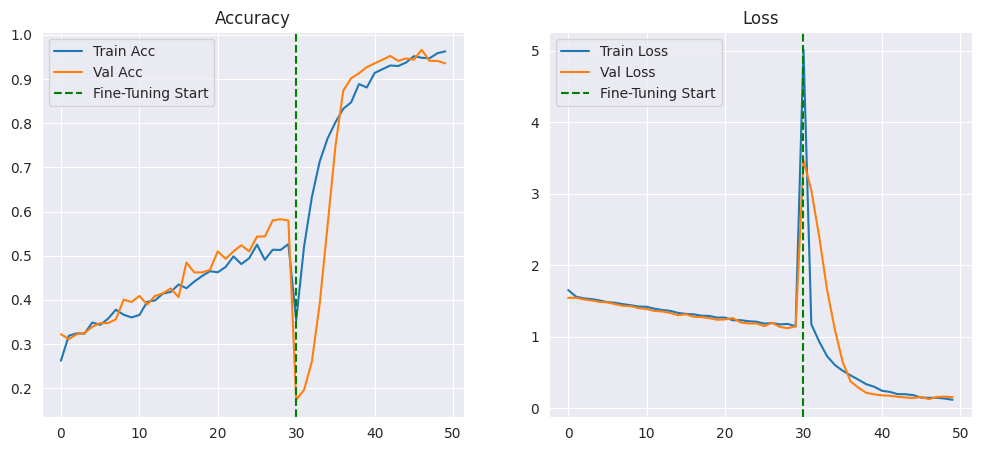

In [5]:
# Cell 5: Advanced Training with Generator & Fine-Tuning

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# 1. Split the Data
# Split: 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training Data:   {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Test Data:       {X_test.shape}")

# 2. Data Generator (RAM-Safe Augmentation)
# This applies shifts on the fly without consuming extra memory
datagen = ImageDataGenerator(
    width_shift_range=0.1,   # Randomly shift time (left/right)
    height_shift_range=0.05, # Randomly shift pitch (up/down)
    fill_mode='nearest'
)

# 3. Phase 1: Train the Head (Frozen Base)
print("\n--- Phase 1: Training Head (Frozen Base) ---")

checkpoint = ModelCheckpoint(
    'best_baby_cry_resnet.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

BATCH_SIZE = 32
EPOCHS_HEAD = 30  # Train head for 30 epochs

history_head = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS_HEAD,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

# 4. Phase 2: Fine-Tuning (Unfreezing)
print("\n--- Phase 2: Fine-Tuning (Unfrozen Base) ---")

# Unfreeze the base model
base_model = model.layers[1] # Access ResNet50V2 layer
base_model.trainable = True

# Freeze the bottom layers (keep generic edges/shapes frozen)
# ResNet50V2 has 190 layers; we unfreeze the top 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a VERY LOW learning rate to prevent destroying weights
model.compile(
    optimizer=Adam(learning_rate=1e-5), # 100x smaller than Phase 1
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 20
TOTAL_EPOCHS = len(history_head.history['loss']) + EPOCHS_FINE

history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=TOTAL_EPOCHS,
    initial_epoch=len(history_head.history['loss']),
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

# 5. Plot Combined History
def plot_full_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.axvline(x=len(h1.history['loss']), color='green', linestyle='--', label='Fine-Tuning Start')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.axvline(x=len(h1.history['loss']), color='green', linestyle='--', label='Fine-Tuning Start')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_full_history(history_head, history_fine)

Best model weights loaded.
Running predictions on Test Set (with TTA)...

Final Test Set Accuracy: 89.36%


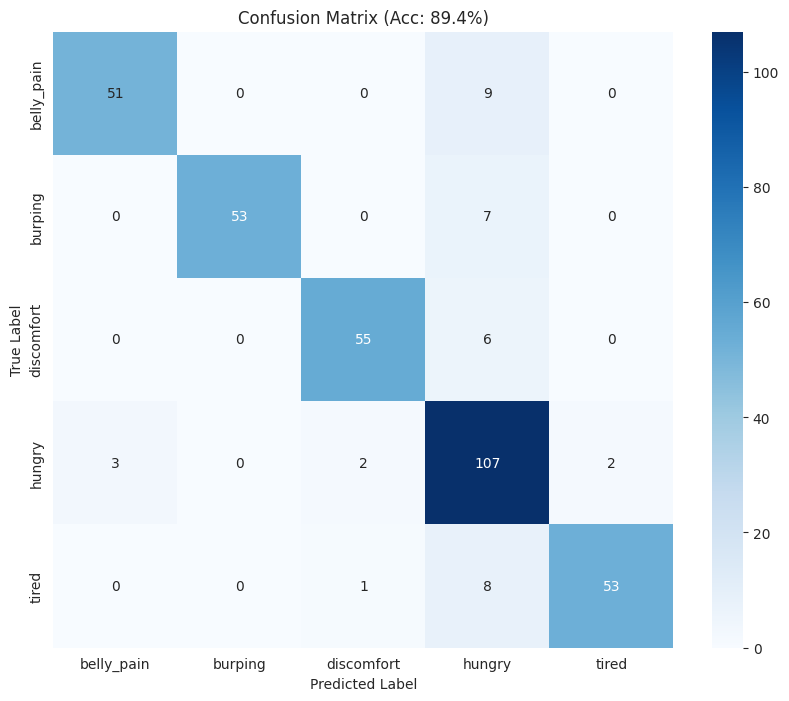


--- Classification Report ---
              precision    recall  f1-score   support

  belly_pain       0.94      0.85      0.89        60
     burping       1.00      0.88      0.94        60
  discomfort       0.95      0.90      0.92        61
      hungry       0.78      0.94      0.85       114
       tired       0.96      0.85      0.91        62

    accuracy                           0.89       357
   macro avg       0.93      0.89      0.90       357
weighted avg       0.91      0.89      0.90       357


--- Single File Demo (Class + Intensity) ---
File: 9CFD61B9-BF13-406D-8B2F-F73CFAAF25CB-1430927728-1.0-f-04-hu.wav
Actual:    HUNGRY
Predicted: HUNGRY (99.99%)
Intensity: 2.0 / 10.0
Status: MILD DISTRESS


In [7]:
# Cell 6 (Fixed): Final Evaluation & Intensity Check

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np

# 1. Load the Best Saved Model
# We load the weights saved by the ModelCheckpoint during training
model.load_weights('best_baby_cry_resnet.keras')
print("Best model weights loaded.")

# 2. Test Time Augmentation (TTA) Function
def predict_with_tta(model, x_test):
    """
    Predicts using Test Time Augmentation.
    For each image, predicts on [Original] and [Horizontal Flip].
    Averages the probabilities for a more robust prediction.
    """
    print("Running predictions on Test Set (with TTA)...")
    predictions = []

    for x in x_test:
        # Create batch of [Original, Flipped]
        batch = np.array([x, np.fliplr(x)])

        # Predict
        preds = model.predict(batch, verbose=0)

        # Average the probabilities (mean of original and flipped)
        avg_pred = np.mean(preds, axis=0)
        predictions.append(avg_pred)

    return np.array(predictions)

# 3. Run Prediction
y_pred_probs = predict_with_tta(model, X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 4. Calculate Final Test Accuracy
test_acc = np.mean(y_pred == y_test)
print(f"\nFinal Test Set Accuracy: {test_acc*100:.2f}%")

# 5. Confusion Matrix
# FIX: Use label_map directly (Int -> String) instead of inverting it
target_names = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Acc: {test_acc*100:.1f}%)')
plt.show()

# 6. Detailed Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

# 7. Real-World Demo (Class + Intensity)
print("\n--- Single File Demo (Class + Intensity) ---")

# Pick a random file from the original dataframe to test
# We filter for a file that actually exists on disk
try:
    random_row = df.sample(1).iloc[0]
    demo_path = random_row['filepath']
    actual_label = random_row['label']

    # Load and process
    y_demo, sr_demo = librosa.load(demo_path, sr=22050, duration=5)

    # Fix length for demo
    target_len = 22050 * 5
    if len(y_demo) < target_len: y_demo = np.pad(y_demo, (0, target_len - len(y_demo)))
    else: y_demo = y_demo[:target_len]

    demo_spec = get_mel_spectrogram_image(y_demo, sr_demo)
    demo_spec = preprocess_input(demo_spec) # Scale for ResNet
    demo_spec = np.expand_dims(demo_spec, axis=0) # Add batch dimension

    # Predict
    pred_prob = model.predict(demo_spec, verbose=0)
    pred_idx = np.argmax(pred_prob)
    pred_label = target_names[pred_idx]
    confidence = pred_prob[0][pred_idx] * 100

    # Calculate Intensity (Signal Processing)
    intensity = calculate_intensity(y_demo, sr_demo)

    print(f"File: {os.path.basename(demo_path)}")
    print(f"Actual:    {actual_label.upper()}")
    print(f"Predicted: {pred_label.upper()} ({confidence:.2f}%)")
    print(f"Intensity: {intensity:.1f} / 10.0")

    if intensity > 7:
        print("Status: HIGH DISTRESS")
    elif intensity > 4:
        print("Status: MODERATE DISTRESS")
    else:
        print("Status: MILD DISTRESS")
except Exception as e:
    print(f"Demo failed: {e}")

In [8]:
# Cell: Save Model
from google.colab import files # Optional: Used for downloading files from Colab

# 1. Define the filename
save_path = 'final_baby_cry_model.keras'

# 2. Save the model
model.save(save_path)
print(f"Model saved successfully as: {save_path}")

# 3. (Optional) Download the model to your local computer
# Uncomment the line below if you want to download the file immediately
# files.download(save_path)

Model saved successfully as: final_baby_cry_model.keras


In [9]:
# Cell: Random Prediction Demo with Audio Playback

import random
import IPython.display as ipd

# 1. Pick a random file from the dataset
# We use the dataframe 'df' created in the Data Loading step
random_index = random.randint(0, len(df) - 1)
sample_row = df.iloc[random_index]

file_path = sample_row['filepath']
actual_label = sample_row['label']

print(f"Selected File: {os.path.basename(file_path)}")
print(f"Actual Label: {actual_label.upper()}")

# 2. Play the Audio
ipd.display(ipd.Audio(file_path))

# 3. Load and Process for the Model
# Load 5 seconds
y_demo, sr_demo = librosa.load(file_path, sr=22050, duration=5)

# Pad if too short (rare, but safe to include)
target_len = 22050 * 5
if len(y_demo) < target_len:
    y_demo = np.pad(y_demo, (0, target_len - len(y_demo)))
else:
    y_demo = y_demo[:target_len]

# Calculate Intensity (Signal Processing)
intensity = calculate_intensity(y_demo, sr_demo)

# Generate Spectrogram Image
demo_spec = get_mel_spectrogram_image(y_demo, sr_demo)
demo_spec = preprocess_input(demo_spec) # Scale for ResNet
demo_input = np.expand_dims(demo_spec, axis=0) # Add batch dimension (1, 224, 224, 3)

# 4. Predict
# We use the 'label_map' from the data loading step to decode the prediction
# label_map maps {0: 'belly_pain', 1: 'burping', ...}
target_names = [label_map[i] for i in range(len(label_map))]

pred_probs = model.predict(demo_input, verbose=0)
pred_idx = np.argmax(pred_probs)
pred_label = target_names[pred_idx]
confidence = pred_probs[0][pred_idx] * 100

# 5. Display Results
print("-" * 30)
print(f"Model Prediction: {pred_label.upper()}")
print(f"Confidence:       {confidence:.2f}%")
print("-" * 30)
print(f"Distress Intensity: {intensity:.1f} / 10.0")

if intensity > 7:
    print("Status: HIGH DISTRESS (Check for Pain/Discomfort)")
elif intensity > 4:
    print("Status: MODERATE DISTRESS (Likely Hungry/Tired)")
else:
    print("Status: MILD DISTRESS (Whimpering/Fussing)")
print("-" * 30)

# Check if correct
if pred_label == actual_label:
    print("CORRECT PREDICTION")
else:
    print("INCORRECT PREDICTION")

Selected File: 5728DDD6-149B-412F-A14B-C29B9B5E415F-1432635047-1.0-m-26-hu.wav
Actual Label: HUNGRY


------------------------------
Model Prediction: HUNGRY
Confidence:       95.56%
------------------------------
Distress Intensity: 6.3 / 10.0
Status: MODERATE DISTRESS (Likely Hungry/Tired)
------------------------------
CORRECT PREDICTION
